In [1]:

import logging
import sys
import numpy as np
from collections import OrderedDict


from braindecode.datasets.bbci import  BBCIDataset
from braindecode.datautil.trial_segment import \
    create_signal_target_from_raw_mne
from braindecode.mne_ext.signalproc import mne_apply, resample_cnt
from braindecode.datautil.signalproc import highpass_cnt
from braindecode.datautil.signalproc import exponential_running_standardize



log = logging.getLogger(__name__)
log.setLevel('DEBUG')

logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                 level=logging.DEBUG, stream=sys.stdout)


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

2019-04-06 18:23:57,011 DEBUG : CACHEDIR=/home/ced/.cache/matplotlib
2019-04-06 18:23:57,034 DEBUG : Using fontManager instance from /home/ced/.cache/matplotlib/fontlist-v300.json
2019-04-06 18:23:57,263 DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-04-06 18:23:57,276 DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-04-06 18:23:57,298 DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
locs =  { "Fp1"   :   (82.7 ,  32.28)
  , "Fpz"   :  ( 90   , -0.1)
  , "Fp2"   :  ( 82.7 , -32.38)
  , "F7"    :  ( 53.6 ,  91.92)
  , "F3"    :  ( 39.1 ,  48)
  , "Fz"    :  ( 35.5 , -0.1)
  , "F4"    :  ( 39.8 , -49.2)
  , "F8"    :  ( 53.8 , -91.56)
  , "FC5"   :  ( 16.1 ,  84.6)
  , "FC1"   :  ( 9.9  ,  27.6)
  , "FC2"   :  ( 10.5 , -28.32)
  , "FC6"   :  ( 16.8 , -85.08)
  , "M1"    :  (-50.6 , 147.36)
  , "T7"    :  (-13.2 , 118.8)
  , "C3"    :  (-16.2 ,  57.48)
  , "Cz"    :  (-16.8 , -0.1)
  , "C4"    :  (-15.5 , -58.68)
  , "T8"    :  (-11.9 , -118.56)
  , "M2"    :  (-51.2 , -147.48)
  , "CP5"   :  (-43   ,  80.76)
  , "CP1"   :  (-39.3 ,  26.4)
  , "CP2"   :  (-38.9 , -27.84)
  , "CP6"   :  (-41.4 , -81.48)
  , "P7"    :  (-76.9 ,  87.48)
  , "P3"    :  (-66.4 ,  44.76)
  , "Pz"    :  (-63.8 , -0.12)
  , "P4"    :  (-66.4 , -45.72)
  , "P8"    :  (-76.7 , -87.36)
  , "POz"   :  (-79.7 , -0.1)
  , "O1"    :  (-104.6,  30.6)
  , "Oz"    :  (-106  ,  -0.1)
  , "O2"    :  (-104.6, -30.48)
  , "AF7"   :  (  73  ,  63.6)
  , "AF3"   :  (  63.7,  33.12)
  , "AF4"   :  (  63.3, -34.32)
  , "AF8"   :  (  73.1, -63.12)
  , "F5"    :  (  45.2,  70.56)
  , "F1"    :  (  36  ,  23.88)
  , "F2"    :  (  36.4, -25.44)
  , "F6"    :  (  45.5, -71.28)
  , "FC3"   :  (  12.2,  56.16)
  , "FCz"   :  (  9.4 ,   -0.1)
  , "FC4"   :  (  13  , -57)
  , "C5"    :  (-15.1 ,  87.48)
  , "C1"    :  (-16.5 ,  28.44)
  , "C2"    :  (-16.3 , -29.64)
  , "C6"    :  (-14.1 , -87.6)
  , "CP3"   :  (-40.9 ,  53.16)
  , "CPz"   :  (-39.3 ,  -0.12)
  , "CP4"   :  (-40.2 , -54.24)
  , "P5"    :  (-70   ,  66.48)
  , "P1"    :  (-65.5 ,  22.08)
  , "P2"    :  (-65.1 , -23.28)
  , "P6"    :  (-70.5 , -67.08)
  , "PO5"   :  (-94.1 ,  47.64)
  , "PO3"   :  (-87.3 ,  31.2)
  , "PO4"   :  (-88   , -31.3)
  , "PO6"   :  (-94.8 , -46.56)
  , "FT7"   :  (23.5  , 112.8)
  , "FT8"   :  (24.6  ,-112.08)
  , "TP7"   :  (-45.8 , 109.08)
  , "TP8"   :  (-45.5 ,-108.84)
  , "PO7"   :  (-88.8 ,  60.36)
  , "PO8"   :  (-88.6 , -60.48)
  , "FT9"   :  (36.4  , 137.4)
  , "FT10"  :  (36.6  ,-137.52)
  , "TPP9h" :  (-67.9 , 112.2)
  , "TPP10h":  (-67.9 ,-112.3)
  , "PO9"   :  (-104  ,  75.48)
  , "PO10"  :  (-103.8, -75.24)
  , "P9"    :  (-87.1 , 110.28)
  , "P10"   :  (-87.4 ,-109.32)
  , "AFF1"  :  (48.3  ,  21.24)
  , "AFz"   :  (60.6  ,  -0.1)
  , "AFF2"  :  (48.9  , -21.84)
  , "FFC5h" :  (28.3  ,  65.76)
  , "FFC3h" :  (24.9  ,  39)
  , "FFC4h" :  (25.4  , -40.68)
  , "FFC6h" :  (28.9  , -67.08)
  , "FCC5h" :  (-1.2  ,  72.6)
  , "FCC3h" :  (-3.1  ,  43.08)
  , "FCC4h" :  (-2.6  , -44.04)
  , "FCC6h" :  (-0.3  , -73.44)
  , "CCP5h" :  (-29.1 ,  70.44)
  , "CCP3h" :  (-28.7 ,  41.4)
  , "CCP4h" :  (-28.1 , -42.72)
  , "CCP6h" :  (-27.9 , -71.4)
  , "CPP5h" :  (-53.4 ,  61.68)
  , "CPP3h" :  (-51.4 ,  36.36)
  , "CPP4h" :  (-50.8 , -37.56)
  , "CPP6h" :  (-52.3 , -62.88)
  , "PPO1"  :  (-75.8 ,  19.92)
  , "PPO2"  :  (-75.4 , -21.12)
  , "I1"    :  (-123.3,  38.28)
  , "Iz"    :  (-129.9,  -0.1)
  , "I2"    :  (-123.5, -37.8)
  , "AFp3h" :  (73.1  ,  18.72)
  , "AFp4h" :  (72.8  , -19.32)
  , "AFF5h" :  (54.2  ,  50.88)
  , "AFF6h" :  (54.7  , -51.48)
  , "FFT7h" :  (34.9  ,  91.56)
  , "FFC1h" :  (22.5  ,  12.36)
  , "FFC2h" :  (22.8  , -14.28)
  , "FFT8h" :  (35.5  , -91.56)
  , "FTT9h" :  (11.2  , 132.6)
  , "FTT7h" :  (2.6   , 102.48)
  , "FCC1h" :  (-3.9  ,  14.28)
  , "FCC2h" :  (-3.8  , -15)
  , "FTT8h" :  (3.6   ,-102.48)
  , "FTT10h":  (11    ,-132.6)
  , "TTP7h" :  (-28.5 , 105.08)
  , "CCP1h" :  (-28.5 ,  13.44)
  , "CCP2h" :  (-28.4 , -14.76)
  , "TTP8h" :  (-28.5 ,-105.18)
  , "TPP7h" :  (-57.6 ,  86.4)
  , "CPP1h" :  (-50   ,  11.64)
  , "CPP2h" :  (-49.7 , -13.44)
  , "TPP8h" :  (-57.6 , -86.88)
  , "PPO9h" :  (-94.3 ,  83.76)
  , "PPO5h" :  (-78.7 ,  49.68)
  , "PPO6h" :  (-78.7 , -49.8)
  , "PPO10h":  (-94.5 , -83.04)
  , "POO9h" :  (-109.5,  51.48)
  , "POO3h" :  (-97.5 ,  17.88)
  , "POO4h" :  (-97.1 , -18.36)
  , "POO10h":  (-109.6, -50.88)
  , "OI1h"  :  (-115.6,  17.28)
  , "OI2h"  :  (-115.6, -16.92)
  }




tight_cap_positions = [
    ['', '', '', '', 'Fp1', 'FPz', 'Fp2', '', '', '', ''],
    ['', '', '', 'AFp3h', '', '', '', 'Afp4h', '', '', ''],
    ['', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', ''],
    ['', '', 'AFF5h', '', 'AFF1', '', 'AFF2', '', 'AFF6h', '', ''],
    ['', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', ''],
    ['FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', '', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h'],
    ['FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10'],
    ['FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', '', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h'],
    ['M1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'M2'],
    ['', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', '', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', ''],
    ['TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10'],
    ['TPP9h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', '', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'TPP10h'],
    ['P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10'],
    ['PPO9h', '', 'PPO5h', '', 'PPO1', '', 'PPO2', '', 'PPO6h', '', 'PPO10h'],
    ['PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10'],
    ['POO9h', '', '', 'POO3h', '', '', '', 'POO4h', '', '', 'POO10h'],
    ['', '', '', '', 'O1', 'Oz', 'O2', '', '', '', ''],
    ['', '', '', '', 'OI1h', '', 'OI2h', '', '', '', ''],
    ['', '', '', '', 'I1', 'Iz', 'I2', '', '', '', '']]




In [4]:
C_sensors = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'CP5',
             'CP1', 'CP2', 'CP6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6',
             'CP3', 'CPz', 'CP4', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h', 'FCC5h',
             'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h', 'CPP5h',
             'CPP3h', 'CPP4h', 'CPP6h', 'FFC1h', 'FFC2h', 'FCC1h', 'FCC2h', 'CCP1h',
             'CCP2h', 'CPP1h', 'CPP2h']


locs = list(map(lambda s: locs[s], C_sensors))

In [5]:
def mapper(locs):
    def actual(values):
        nmap = np.empty((19, 11))
        for i, row in enumerate(tight_cap_positions):
            for j, col in enumerate(row):
                if col in locs:
                    ind = locs.index(col)
                    nmap[i, j] = values[ind]
                else:
                    nmap[i, j] = np.nan
        return nmap
    return actual

def mapper2(locs):
    pass

In [6]:
a = mapper(C_sensors)

In [15]:
cnt = None
def load_bbci_data(filename, low_cut_hz, debug=False):
    global cnt
    load_sensor_names = None
    if debug:
        load_sensor_names = ['C3', 'C4', 'C2']
    # we loaded all sensors to always get same cleaning results independent of sensor selection
    # There is an inbuilt heuristic that tries to use only EEG channels and that definitely
    # works for datasets in our paper
    loader = BBCIDataset(filename, load_sensor_names=load_sensor_names)

    log.info("Loading data...")
    cnt = loader.load()

    # Cleaning: First find all trials that have absolute microvolt values
    # larger than +- 800 inside them and remember them for removal later
    log.info("Cutting trials...")

    marker_def = OrderedDict([('Right Hand', [1]), ('Left Hand', [2],),
                              ('Rest', [3]), ('Feet', [4])])
    clean_ival = [0, 4000]

    set_for_cleaning = create_signal_target_from_raw_mne(cnt, marker_def,
                                                  clean_ival)

    clean_trial_mask = np.max(np.abs(set_for_cleaning.X), axis=(1, 2)) < 800

    log.info("Clean trials: {:3d}  of {:3d} ({:5.1f}%)".format(
        np.sum(clean_trial_mask),
        len(set_for_cleaning.X),
        np.mean(clean_trial_mask) * 100))

    # now pick only sensors with C in their name
    # as they cover motor cortex
    C_sensors = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'CP5',
                 'CP1', 'CP2', 'CP6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2',
                 'C6',
                 'CP3', 'CPz', 'CP4', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h',
                 'FCC5h',
                 'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h',
                 'CPP5h',
                 'CPP3h', 'CPP4h', 'CPP6h', 'FFC1h', 'FFC2h', 'FCC1h', 'FCC2h',
                 'CCP1h',
                 'CCP2h', 'CPP1h', 'CPP2h']
    if debug:
        C_sensors = load_sensor_names
    return
    # cnt = cnt.pick_channels(C_sensors)

    # Further preprocessings as descibed in paper
    log.info("Resampling...")
    cnt = resample_cnt(cnt, 250.0)
    log.info("Highpassing...")
    cnt = mne_apply(
        lambda a: highpass_cnt(
            a, low_cut_hz, cnt.info['sfreq'], filt_order=3, axis=1),
        cnt)
    log.info("Standardizing...")
    cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=1e-3,
                                                  init_block_size=1000,
                                                  eps=1e-4).T,
        cnt)

    # Trial interval, start at -500 already, since improved decoding for networks
    ival = [-500, 4000]

    dataset = create_signal_target_from_raw_mne(cnt, marker_def, ival)
    dataset.X = dataset.X[clean_trial_mask]
    dataset.y = dataset.y[clean_trial_mask]
    return dataset

In [8]:
filename = "/media/ced/HDD/Coding/high-gamma-dataset/data/train/1.mat"
low_cut_hz = 4

In [16]:
data = load_bbci_data(filename=filename, low_cut_hz=low_cut_hz)

2019-04-06 18:45:13,781 INFO : Loading data...
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
2019-04-06 18:45:32,900 INFO : Cutting trials...
2019-04-06 18:45:35,354 INFO : Trial per class:
Counter({'Feet': 80, 'Right Hand': 80, 'Left Hand': 80, 'Rest': 80})
2019-04-06 18:45:37,471 INFO : Clean trials: 319  of 320 ( 99.7%)


In [29]:
cnt.ch_names

['Fp1',
 'Fp2',
 'Fpz',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'M1',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'M2',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'POz',
 'O1',
 'Oz',
 'O2',
 'AF7',
 'AF3',
 'AF4',
 'AF8',
 'F5',
 'F1',
 'F2',
 'F6',
 'FC3',
 'FCz',
 'FC4',
 'C5',
 'C1',
 'C2',
 'C6',
 'CP3',
 'CPz',
 'CP4',
 'P5',
 'P1',
 'P2',
 'P6',
 'PO5',
 'PO3',
 'PO4',
 'PO6',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'FT9',
 'FT10',
 'TPP9h',
 'TPP10h',
 'PO9',
 'PO10',
 'P9',
 'P10',
 'AFF1',
 'AFz',
 'AFF2',
 'FFC5h',
 'FFC3h',
 'FFC4h',
 'FFC6h',
 'FCC5h',
 'FCC3h',
 'FCC4h',
 'FCC6h',
 'CCP5h',
 'CCP3h',
 'CCP4h',
 'CCP6h',
 'CPP5h',
 'CPP3h',
 'CPP4h',
 'CPP6h',
 'PPO1',
 'PPO2',
 'I1',
 'Iz',
 'I2',
 'AFp3h',
 'AFp4h',
 'AFF5h',
 'AFF6h',
 'FFT7h',
 'FFC1h',
 'FFC2h',
 'FFT8h',
 'FTT9h',
 'FTT7h',
 'FCC1h',
 'FCC2h',
 'FTT8h',
 'FTT10h',
 'TTP7h',
 'CCP1h',
 'CCP2h',
 'TTP8h',
 'TPP7h',
 'CPP1h',
 'CPP2h',
 'TPP8h',
 'PP

In [10]:
d = data.X[0, :, 0]

In [11]:
d = d - d.mean()

2019-04-06 18:24:49,118 DEBUG : update_title_pos
2019-04-06 18:24:49,174 DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ced/.local/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-04-06 18:24:49,234 DEBUG : update_title_pos
2019-04-06 18:24:49,305 DEBUG : update_title_pos
2019-04-06 18:24:49,370 DEBUG : update_title_pos
2019-04-06 18:24:49,404 DEBUG : update_title_pos


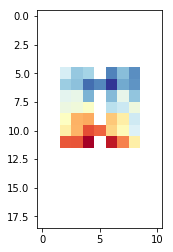

In [12]:
plt.imshow(a(d), cmap='RdYlBu')

In [13]:
# for each of the channels, remove the mean value of all at this current timestamp